### Dealing with Bias-Variance-Tradeoff

Implement regularized linear regression to predict the amount of water 
owing out of a dam using the change
of water level in a reservoir.

<img src="./images/bias_variance.png" width="400" />

1. Bias issue = > Plot Learning Curve with/without polynomial approach 
2. Overfitting issue => Plot Learning Curve with/without Regularisation 
3. Hyperparameter Validation => Using validation set to choose hyperparameter paramenter (e.g. regularisation lambda)



In [590]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.io import loadmat
import warnings; warnings.simplefilter('ignore')

#### Data Visualisation & Dataset split

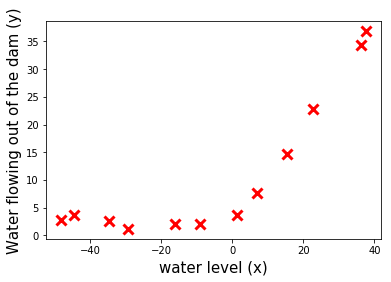

In [612]:
data = loadmat('./data/bias_variance.mat')
Xtrain = data['X']; m1 = Xtrain.shape[0]; ytrain = data['y']
Xval = data['Xval'];m2 = Xval.shape[0];yval = data['yval']
Xtest = data['Xtest'];m3 = Xtest.shape[0]; ytest = data['ytest']

plt.plot(Xtrain, ytrain, 'rx', markersize=10, mew=3)
plt.xlabel('water level (x)', fontsize=15)
plt.ylabel('Water flowing out of the dam (y)', fontsize=15)
plt.show()

##### Bias-Variance-Tradeoff Evaluation Functions

In [629]:
def polyFeature(X, degree):
    """polynominal features creation x**0 + x**1 + x**2 ... for X
    """
    return np.array([np.squeeze(X)**i for i in range(1,degree+1)]).T

def normalization(X):
    m = X.shape[0]
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    return (X-mu)/sigma, mu, sigma


def costFunction(theta, X, y, lambda_val):
    m = len(y) 
    theta = theta.reshape(-1,1)   # VERY IMPORTANT !!! theta is (2,) after using minimize_tnc function!
    J = 1./(2*m)*np.sum( (X.dot(theta) - y)**2 ) \
        + lambda_val/(2*m)*(theta[1:].T.dot(theta[1:]))
    return J

def gradient(theta, X, y, lamda):
    theta = theta.reshape(-1,1)
    m,n = X.shape[0], X.shape[1]
    grad= np.zeros(theta.shape)
    grad = 1.0/m*(X.T).dot(X.dot(theta)-y) + lamda/m*theta
    grad[0] = grad[0] - lamda/m*theta[0]
    return grad

def trainLinearReg(X,y, lamda):
    """theta optimisation function with the a truncated Newton (TNC) algorithm
    """
    initial_theta = np.zeros((X.shape[1],1))
    xopt = minimize(costFunction, x0=initial_theta, args = (X,y,lamda), \
                    jac = gradient, method='TNC', options={})
#    print(xopt)
    theta = xopt['x']
    return theta


def learningCurve(X, y, Xval, yval, lambda_val):
    """Plot learning curveGenerates with train/val error
    """
    m = X.shape[0]
    error_train = np.zeros((m,1))
    error_val   = np.zeros((m,1))
    for i in range(1,m+1):
        Xsubtrain = X[:i]
        ysubtrain = y[:i]
        theta = trainLinearReg(Xsubtrain, ysubtrain, lambda_val)
        # when calculate error computation, we should set lambda_val=0.
        error_train[i-1,:]= costFunction( theta, Xsubtrain, ysubtrain, 0)
        error_val[i-1,:] = costFunction(  theta, Xval   , yval   , 0)
    return error_train, error_val

def plotFit(min_x, max_x, mu, sigma, theta, degree, left, right):
    """Generate incremental x for fitting curve plotting.
    """
    x = np.arange(min_x - left, max_x + right, 0.05)
    X_poly = polyFeature(x, degree)
    X_poly = (X_poly - mu) / sigma
    X_poly = np.column_stack((np.ones((x.shape[0],1)), X_poly))

    plt.plot(x, np.dot(X_poly, theta), '--', linewidth=2)

def validationCurve(X, y, Xval, yval):
    """for-loop for different lambda to obtain validation error, select then the best lambda
    """
    lambda_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
    error_train = np.zeros((len(lambda_vec), 1))
    error_val = np.zeros((len(lambda_vec), 1))

    for i in range(len(lambda_vec)):
        lambda_val = lambda_vec[i]
        theta = trainLinearReg(X, y, lambda_val)
        error_train[i] = costFunction(theta, X,    y , 0)
        error_val[i]   = costFunction(theta, Xval, yval,  0)        
    return lambda_vec, error_train, error_val


##### First Fitting 
    with lambda = 0, no polynominal approach, no normalisation.

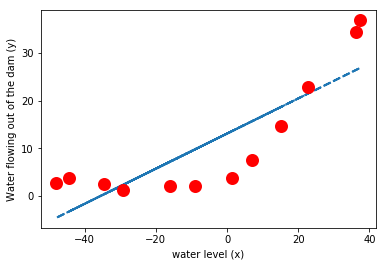

In [630]:
lambda_val = 0
Xtrain1 = np.append(np.ones((m1,1)),Xtrain, axis=1)
theta = trainLinearReg(Xtrain1, y, lambda_val)
plt.plot(Xtrain, np.dot(Xtrain1, theta), '--', linewidth=2)
plt.plot(Xtrain, ytrain, 'ro', markersize=10, mew=3)
plt.xlabel('water level (x)', fontsize=10)
plt.ylabel('Water flowing out of the dam (y)', fontsize=10)
plt.show()

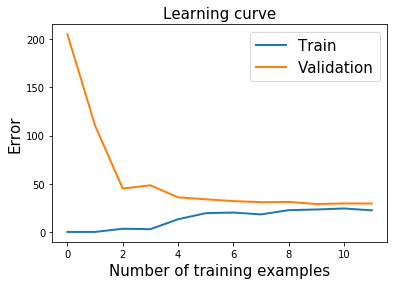

In [631]:
# Plot learning curve
lambda_val = 0
error_train, error_val = learningCurve(np.column_stack((np.ones((m1,1)), Xtrain)), ytrain, 
                                       np.column_stack((np.ones((m2, 1)), Xval)), yval,lambda_val)
p1, p2 = plt.plot(range(m1), error_train, range(m1), error_val, linewidth=2)
plt.title('Learning curve', fontsize=10)
legend = plt.legend((p1, p2), ('Train', 'Validation'),fontsize=10)
plt.xlabel('Number of training examples', fontsize=10)
plt.ylabel('Error', fontsize=10)
plt.show()

#### Non-Regularized polynomial regression

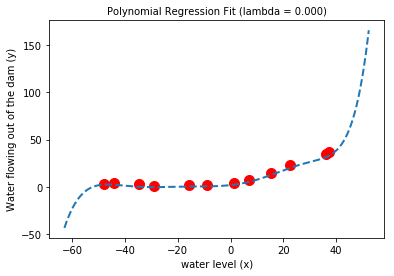

In [636]:
degree = 8  # polynomial degree
Xtrain2 = polyFeature(Xtrain,degree)
Xval2 = polyFeature(Xval,degree)
Xtrain2, mu, sigma = normalization(Xtrain2)
Xval2, mu, sigma = normalization(Xval2)

Xtrain2 = np.append(np.ones((m1,1)),Xtrain2, axis=1)
Xval2 = np.append(np.ones((m2,1)),Xval2, axis=1)
lambda_val = 0
theta = trainLinearReg(Xtrain2, ytrain, lambda_val)

plt.plot(Xtrain, ytrain, 'ro', markersize=10)
plotFit(min(Xtrain), max(Xtrain), mu, sigma, theta, degree, left=15, right=15)
plt.xlabel('water level (x)', fontsize=10) 
plt.ylabel('Water flowing out of the dam (y)', fontsize=10)
plt.title ('Polynomial Regression Fit (lambda = {:.3f})'.format(lambda_val), fontsize=10)
plt.show()

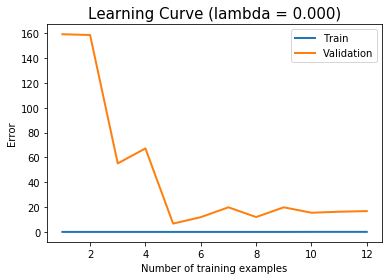

In [637]:
# Learn Curves changes after polynomial fitting
lambda_val = 0
error_train, error_val = learningCurve(Xtrain2, y, Xval2, yval, lambda_val)
p1, p2 = plt.plot(range(1,m+1), error_train, range(1,m+1), error_val, linewidth=2)

legend = plt.legend((p1, p2), ('Train', 'Validation'), fontsize=10)

plt.title('Learning Curve (lambda = {:.3f})'.format(lambda_val), fontsize=15)
plt.xlabel('Number of training examples', fontsize=10)
plt.ylabel('Error', fontsize=10)
plt.show()

#### Regularized polynomial regression (with lambda = 1)

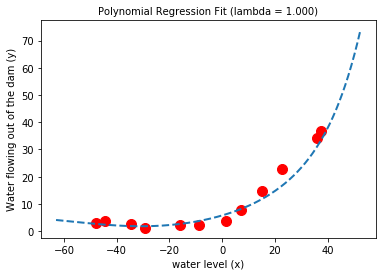

In [639]:
degree = 8  # polynomial degree
Xtrain2 = polyFeature(Xtrain,degree)
Xval2 = polyFeature(Xval,degree)
Xtrain2, mu, sigma = normalization(Xtrain2)
Xval2, mu, sigma = normalization(Xval2)

Xtrain2 = np.append(np.ones((m1,1)),Xtrain2, axis=1)
Xval2 = np.append(np.ones((m2,1)),Xval2, axis=1)
lambda_val = 1
theta = trainLinearReg(Xtrain2, ytrain, lambda_val)

plt.plot(Xtrain, ytrain, 'ro', markersize=10)
plotFit(min(Xtrain), max(Xtrain), mu, sigma, theta, degree, left=15, right=15)
plt.xlabel('water level (x)', fontsize=10) 
plt.ylabel('Water flowing out of the dam (y)', fontsize=10)
plt.title ('Polynomial Regression Fit (lambda = {:.3f})'.format(lambda_val), fontsize=10)
plt.show()

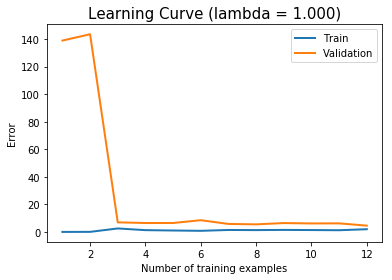

In [641]:
# Learn Curves changes after polynomial fitting
lambda_val = 1
error_train, error_val = learningCurve(Xtrain2, y, Xval2, yval, lambda_val)
p1, p2 = plt.plot(range(1,m+1), error_train, range(1,m+1), error_val, linewidth=2)

legend = plt.legend((p1, p2), ('Train', 'Validation'), fontsize=10)

plt.title('Learning Curve (lambda = {:.3f})'.format(lambda_val), fontsize=15)
plt.xlabel('Number of training examples', fontsize=10)
plt.ylabel('Error', fontsize=10)
plt.show()

#### Regularisation parameter validation 

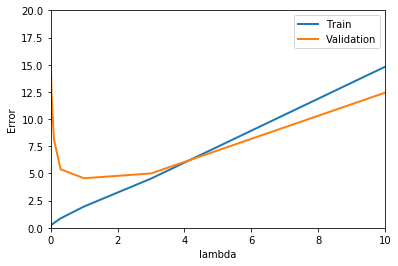

In [645]:
lambda_vec, error_train, error_val = validationCurve(Xtrain2, ytrain, Xval2, yval)

p1, p2 = plt.plot(lambda_vec, error_train, lambda_vec, error_val, linewidth=2)
legend = plt.legend((p1, p2), ('Train', 'Validation'), fontsize=10)
plt.xlabel('lambda', fontsize=10)
plt.ylabel('Error', fontsize=10)
plt.axis([0, 10, 0, 20])
plt.show()

#### Evaluation on testset with the optimized lambda

In [644]:
lambda_val = 1
theta = trainLinearReg(Xtrain2, ytrain, lambda_val)
error_test = costFunction( theta, Xtest2, ytest, 0)
print('Testset error: {}\n'.format(error_test))

Testset error: [[7.85157857]]

